In [25]:
# ============================================
# EARLY STAGE DIABETES RISK — MODELLING NOTEBOOK
# ============================================

CSV_PATH = "C:/Users/benni/Documents/Software 2/Machine Learning/Projekt/bedste-gruppe-ml/data/raw_data/mushroom_raw_data.csv"


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

print("Libraries loaded.")


Libraries loaded.


In [31]:
# 1) LOAD & CLEAN DATA
df = pd.read_csv(CSV_PATH)

text_map = {
    'EDIBLE' : 0,
    'POISONOUS' : 1
}

df = df.replace(text_map)

df.head()


C:\Users\benni\AppData\Local\Temp\ipykernel_23792\1282803894.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(text_map)


,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,0,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,0,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,0,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,0,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [32]:
# 2) DEFINE FEATURES & TARGET
if "poisonous" not in df.columns:
    raise ValueError("Target column 'class' not found. Please verify your dataset.")
#Drop unnecessary columns
columns_to_drop = [
    "stalk-root", #many missing values
    "veil-type" #only one category

]
df.drop(columns=columns_to_drop, inplace=True)

x = df.drop(columns=["poisonous"]) #features minus target
y = df["poisonous"] #target

# Identify columns by dtype for preprocessing
cat_cols = x.columns.tolist()

print("Categorical columns:", cat_cols)
print("Target distribution:\n", y.value_counts(normalize=True))


Categorical columns: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Target distribution:
 poisonous
0    0.53327
1    0.46673
Name: proportion, dtype: float64


In [33]:
# 3) TRAIN/TEST SPLIT (stratified to preserve class balance)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)
x_train.shape, x_test.shape


((6732, 20), (1684, 20))

In [34]:
# 4) PREPROCESSOR
# - OneHotEncode categorical strings (if any)
# - StandardScale numeric (useful for LR/SVM/NN; safe for trees)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)


LogReg Accuracy: 0.997624703087886
LogReg F1: 0.9974489795918368

Classification Report (LogReg):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       898
           1       1.00      0.99      1.00       786

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

LogReg ROC-AUC: 1.0


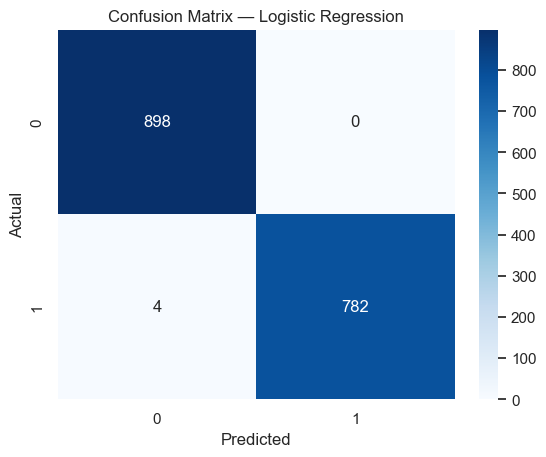

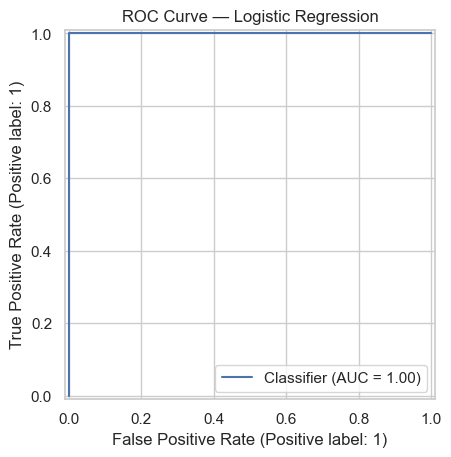

In [38]:
# 5) BASELINE MODEL — LOGISTIC REGRESSION
# (Clear, interpretable; benefits from scaling)
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])
log_reg.set_output(transform="default")  # to get feature names after OHE
log_reg.fit(x_train, y_train)
pred_lr = log_reg.predict(x_test)
proba_lr = log_reg.predict_proba(x_test)[:, 1]

print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print("LogReg F1:", f1_score(y_test, pred_lr))
print("\nClassification Report (LogReg):\n", classification_report(y_test, pred_lr))

# ROC-AUC (if binary)
try:
    print("LogReg ROC-AUC:", roc_auc_score(y_test, proba_lr))
except Exception:
    pass

cm_lr = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

try:
    RocCurveDisplay.from_predictions(y_test, proba_lr)
    plt.title("ROC Curve — Logistic Regression")
    plt.show()
except Exception:
    pass


RF Accuracy: 1.0
RF F1: 1.0

Classification Report (RF):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       898
           1       1.00      1.00      1.00       786

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

RF ROC-AUC: 1.0


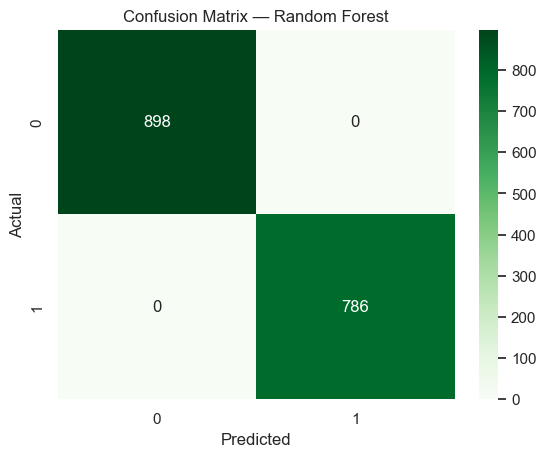

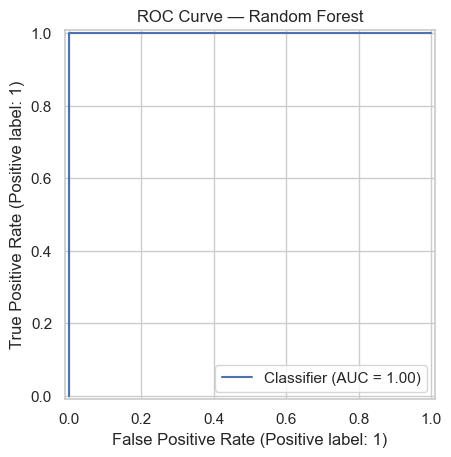

In [39]:
# 6) ROBUST MODEL — RANDOM FOREST
# (Works well with mixed/binary features, minimal tuning)
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# Some RF implementations expose predict_proba; ColumnTransformer keeps feature space
try:
    proba_rf = rf.predict_proba(X_test)[:, 1]
except Exception:
    # If not available (should be), fake uniform probs to keep code safe
    proba_rf = np.full_like(y_test, fill_value=float(np.mean(y_train)), dtype=float)

print("RF Accuracy:", accuracy_score(y_test, pred_rf))
print("RF F1:", f1_score(y_test, pred_rf))
print("\nClassification Report (RF):\n", classification_report(y_test, pred_rf))

try:
    print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf))
except Exception:
    pass

cm_rf = confusion_matrix(y_test, pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

try:
    RocCurveDisplay.from_predictions(y_test, proba_rf)
    plt.title("ROC Curve — Random Forest")
    plt.show()
except Exception:
    pass


In [41]:
# 7) SIMPLE FEATURE IMPORTANCE (model-dependent)
# We'll refit a standalone RF on preprocessed numeric data to extract importances cleanly.
# For a production approach, keep track of one-hot feature names; here we keep it simple.

# Create fully transformed train to get feature names for OHE + scaler
ohe = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()

from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(transform_output="default")  # so we get a DataFrame back with column names

ct = make_column_transformer(
    (ohe, cat_cols),
    remainder="drop"
)

Xtr_df = ct.fit_transform(x_train)
rf_raw = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf_raw.fit(Xtr_df, y_train)

importances = pd.Series(rf_raw.feature_importances_, index=Xtr_df.columns).sort_values(ascending=True)

plt.figure(figsize=(8, max(6, 0.3*len(importances))))
importances.tail(20).plot(kind="barh")
plt.title("Top Feature Importances (Random Forest on Transformed Features)")
plt.show()

display(importances.sort_values(ascending=False).head(20))


AttributeError: 'csr_matrix' object has no attribute 'columns'

In [10]:
# 8) SUMMARY & NEXT STEPS
print(f"""
SUMMARY
-------
• We trained two models:
  - Logistic Regression (interpretable baseline, scales features)
  - Random Forest (robust, low-prep)
• Metrics show how well each model predicted diabetes risk on unseen data.
• Confusion matrices reveal where models make mistakes.
• Feature importance highlights strong indicators (e.g., Polyuria, Polydipsia, Sudden weight loss, etc.).

NEXT STEPS
----------
• If required, try class-weight balancing or thresholds optimization.
• Consider calibration if you need reliable probabilities.
• Package the best pipeline (preprocess + model) for inference.
""")



SUMMARY
-------
• We trained two models:
  - Logistic Regression (interpretable baseline, scales features)
  - Random Forest (robust, low-prep)
• Metrics show how well each model predicted diabetes risk on unseen data.
• Confusion matrices reveal where models make mistakes.
• Feature importance highlights strong indicators (e.g., Polyuria, Polydipsia, Sudden weight loss, etc.).

NEXT STEPS
----------
• If required, try class-weight balancing or thresholds optimization.
• Consider calibration if you need reliable probabilities.
• Package the best pipeline (preprocess + model) for inference.

